In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point,MultiPoint,MultiPolygon,Polygon,box
from shapely import wkt
from descartes.patch import PolygonPatch
import ipywidgets as widgets
import ipywidgets.widgets.interaction
import random
import pandas as pd

import re

from shapely import geometry
import pickle
import time

from ipyparallel import Client

from shapely import affinity
from shapely.geometry import LineString
import warnings
warnings.simplefilter('ignore', np.RankWarning)



In [2]:
pwd()

'/media/charly/Data/Lab/Projects/uJ/experiments_ms_pBGT/MGGT-AMP-Pulse'

In [3]:
path_to_uj="/home/esb/Projects/uJ/local/current/uJ_src_SingleChan/python/"
path_to_uj='/home/charly/Lab/Projects/uJ/local/current/uJ_src_SingleChan/python/'

sys.path.insert(0, path_to_uj)


In [4]:
%load_ext autoreload

In [5]:
#%autoreload 
from readroi import *
from DataManagers import *
from TrackingFunctions import *
from PlottingFunctions import *


Importing readroi
DataStructs...1loaded!
DataManagers...loaded!
TrackingFunctions... 1loaded!
PlottingFunctions... loaded p2!


In [6]:
%autoreload 2

## Note 
### Start a cluster with ipcluster start or in notebook main menu

## Experiment Parameters

In [7]:

uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data/"
#uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data_online/"


expeLabel="MGGT-AMP-Pulse"

rootDir=uj_data_path+"MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/"

trap_list="xy01,xy04,xy05,xy06,xy07,xy09,xy12,xy13".split(",")

print(rootDir)


toFile=True
#Parameters 

frame2min=10

figxlim=640
figylim=512
flims=(figxlim,figylim)


frame_experiment_start=10;
frame_experiment_end=34
frame_signal_start=16
frame_signal_end=20
frame_norm_start=10
frame_norm_end=15                  ### trick
frame_analysis_end=34



t_experiment_start=0
t_signal_start=(frame_signal_start-frame_experiment_start)*frame2min  
t_signal_end=(frame_signal_end-frame_experiment_start)*frame2min
t_experiment_end=(frame_experiment_end-frame_experiment_start)*frame2min

frames=range(int(frame_experiment_start),int(frame_experiment_end+1))
frames_list=[x for x in frames]
times=[(this_frame-frame_experiment_start)*frame2min for this_frame in frames]
times_hour=[(this_frame-frame_experiment_start)*frame2min/60 for this_frame in frames]




data_type="normData"

for trap in trap_list:
    #Input files
    dirNameROIs=rootDir+"data_rois/"+trap+"/MERGE/"
    #dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    
    #Output
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameCELLS):
        print("making dir cells...")
        os.makedirs(dirNameCELLS)

    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameTRACKEDCELLS):
        print("making dir tracked cells...")
        os.makedirs(dirNameTRACKEDCELLS)

    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameFIGURES):
        print("making dir figures/tracked_cells ... %s"%trap,end="\r")
        os.makedirs(dirNameFIGURES)



#Prepare file system
dataPath="%sdata/GFP/"%rootDir


/home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...
making dir cells...
making dir tracked cells...


___
# Create Cells


### Process ROIs (parallel version)

In [8]:
def par_process_rois():
    
    import numpy as np
    
    def get_max_x_angle(poly):
        rangle=0
        angles= list(range(0,185,5))
        (bminx, bminy, bmaxx, bmaxy)=poly.bounds
        xl=bmaxx-bminx
        yl=bmaxy-bminy
        center=Point((xl/2)+bminx,(yl/2)+bminy)

        max_xrange=xl
        for i,angle in enumerate(angles):
            #print(i,angle)
            poly_t=affinity.rotate(poly,angle,center)
            (bminx, bminy, bmaxx, bmaxy)=poly_t.bounds
            xl=bmaxx-bminx

            if(xl>max_xrange):
                max_xrange=xl
                rangle=angle

        return rangle,center
    
    def fix_poly(p):
        buff=0
        while(p.is_valid==False or p.geom_type is not "Polygon"):
            p=p.buffer(buff)
            p=wkt.loads(wkt.dumps(p, rounding_precision=2)).simplify(0)
            #print(buff)
            buff+=.001

        return p


    def get_cell_axis(poly):
      #  t=time.time()
        line=LineString()
        pre_cloud=[]
        angle,center=get_max_x_angle(poly)
        poly=affinity.rotate(poly, angle,center )
        poly=fix_poly(poly)
        ext=poly.exterior.coords

        decs=0
        for i,seed_point in enumerate(ext):
            pre_cloud_i=[]
            seed_point=Point(seed_point)
            i=.5;
            intersection=poly.exterior.intersection(seed_point)
            sphere=seed_point.buffer(i)
            intersection=poly.exterior.intersection(sphere.exterior)
            #while(len(list(intersection))>0):
            while(intersection.is_empty==False):
                arc=Point()
                sphere=seed_point.buffer(i)
                intersection=poly.exterior.intersection(sphere.exterior)
                i+=3
                #i+=.5
    #             if(len(list(intersection))<=1):
    #                 continue
                if(intersection.is_empty):
                    continue

                arc=poly.intersection(sphere.exterior)

                if(arc.geom_type=="MultiLineString"):

                    for this_geom in arc.geoms:
                        arc_xy=list(this_geom.coords)

                        for pi in arc_xy:
                            pi=Point(pi)
                            pre_cloud_i.append((round(pi.x,decs),round(pi.y,decs)))

                elif(arc.geom_type=="LineString"):
                    for pi in list(arc.coords):
                        pi=Point(pi) 
                        pre_cloud_i.append((round(pi.x,decs),round(pi.y,decs)))

            pre_cloud.append(pre_cloud_i)

        cloud=MultiPoint(pre_cloud[0])

        for line in pre_cloud:

            line=MultiPoint(line)
            cloud=cloud.union(line)

        ###make poly fit to points cloud
        xs=[]
        ys=[]
        for pi in cloud:
            pi=Point(pi)

            xs.append(pi.x)
            ys.append(pi.y)

        pf=np.poly1d(np.polyfit(xs,ys,25))
        xr=np.linspace(np.min(xs),np.max(xs),100)

        line=[]
        for x in xr:
            pi=Point(x,pf(x))
            line.append(pi)

        line=LineString(line)
        linexy=np.array(line)
        linex=linexy[:,0]
        liney=linexy[:,1]

        line=poly.intersection(line)
        liner=affinity.rotate(line,-angle,center)
        if(liner.geom_type=="MultiLineString"):
            line=LineString()
            for this_geom in liner.geoms:
                if(this_geom.length>line.length):
                    line=this_geom
            liner=line

        linexy=np.array(liner)
        linex=linexy[:,0]
        liney=linexy[:,1]

        x=(np.max(xs)-np.min(xs))/2+np.min(xs)
        pi=Point(x,pf(x))

        center=affinity.rotate(pi,-angle,center)

        return liner,center
    
    frame_axis=[]
    frame_centers=[]
    
    for j,this_roi in enumerate(rois):
        
        this_axis,this_center=get_cell_axis(this_roi)
            
        frame_axis.append(this_axis)
        frame_centers.append(this_center)
    ret=[rois, roiIDs, frame_axis, frame_centers]
    return ret



### Load ROIs generated by uJ

In [9]:

fileROIs=load_rois(dirNameROIs)
dataFiles=load_data_files(dirNameDATA)
numFrames=len(fileROIs)
print('Loading %s frames'%numFrames)
print('Loading %s data files'%len(dataFiles))
#frame_experiment_end=23

fileROIs=fileROIs[0:frame_experiment_end-frame_experiment_start+1]
dataFiles=dataFiles[0:frame_experiment_end-frame_experiment_start+1]

# fx=frame_experiment_end-frame_experiment_start
# fileROIs=fileROIs[fx:frame_experiment_end-frame_experiment_start+1]
# dataFiles=dataFiles[fx:frame_experiment_end-frame_experiment_start+1]



numFrames=len(fileROIs)
print('Loading  %s frames'%numFrames,fileROIs)
print('Loading %s data files'%len(dataFiles))

    
   ##### NOTE if path not found check the NAME of your local sync folder 

Loading 25 frames
Loading 25 data files
Loading  25 frames ['MGGT-AMP-Pulse_xy13_010.zip', 'MGGT-AMP-Pulse_xy13_011.zip', 'MGGT-AMP-Pulse_xy13_012.zip', 'MGGT-AMP-Pulse_xy13_013.zip', 'MGGT-AMP-Pulse_xy13_014.zip', 'MGGT-AMP-Pulse_xy13_015.zip', 'MGGT-AMP-Pulse_xy13_016.zip', 'MGGT-AMP-Pulse_xy13_017.zip', 'MGGT-AMP-Pulse_xy13_018.zip', 'MGGT-AMP-Pulse_xy13_019.zip', 'MGGT-AMP-Pulse_xy13_020.zip', 'MGGT-AMP-Pulse_xy13_021.zip', 'MGGT-AMP-Pulse_xy13_022.zip', 'MGGT-AMP-Pulse_xy13_023.zip', 'MGGT-AMP-Pulse_xy13_024.zip', 'MGGT-AMP-Pulse_xy13_025.zip', 'MGGT-AMP-Pulse_xy13_026.zip', 'MGGT-AMP-Pulse_xy13_027.zip', 'MGGT-AMP-Pulse_xy13_028.zip', 'MGGT-AMP-Pulse_xy13_029.zip', 'MGGT-AMP-Pulse_xy13_030.zip', 'MGGT-AMP-Pulse_xy13_031.zip', 'MGGT-AMP-Pulse_xy13_032.zip', 'MGGT-AMP-Pulse_xy13_033.zip', 'MGGT-AMP-Pulse_xy13_034.zip']
Loading 25 data files


In [11]:
re_do_cells=False
re_do_cells=True
trap_cells=[]

#trap_list="xy01,xy04,xy05,xy07,xy09,xy12,xy13".split(",")  #temp no 06
#trap_list="xy13".split(",")  #temp no 06


for trap in trap_list:
    dirNameROIs=rootDir+"data_rois/"+trap+"/MERGE/"
    dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    fileROIs=load_rois(dirNameROIs)
    dataFiles=load_data_files(dirNameDATA)
    numFrames=len(fileROIs)
    print('Loading %s frames'%numFrames)
    #print('Loading %s data files'%len(dataFiles))

    fileROIs=fileROIs[0:frame_experiment_end-frame_experiment_start+1]
    dataFiles=dataFiles[0:frame_experiment_end-frame_experiment_start+1]
    
    
    if re_do_cells:
        rc = Client()
        dview = rc[:]
        with rc[:].sync_imports(): 
            
            from shapely.geometry import Point,LineString,MultiPoint
            from shapely import affinity,wkt
            
            

        global cells  # global?
        cells=[]
        for frame, this_file in enumerate(fileROIs):
            [rois,roiIDs]=load_frame('%s%s'%(dirNameROIs,this_file))
            this_data_file="%s%s"%(dirNameDATA,dataFiles[frame])


            print("\n(Parallel) Processing %s ROIs from %s"%(len(rois),this_file))


            tic()

            #First scatter rois
            dview.scatter('rois', rois)
            dview.scatter('roiIDs', roiIDs)

            #Asynchronous execution of par_process_rois
            ret=dview.apply_async(par_process_rois)

            #Now gather results
            frame_rois = []
            frame_roiIDs = []
            frame_axis = []
            frame_center = []

            ret_proc=ret.get()
            for i in rc.ids:
                frame_rois.append(ret_proc[i][0])
                frame_roiIDs.append(ret_proc[i][1])
                frame_axis.append(ret_proc[i][2])
                frame_center.append(ret_proc[i][3])

            frame_rois=[y for x in frame_rois for y in x]
            frame_roiIDs=[y for x in frame_roiIDs for y in x]
            frame_axis=[y for x in frame_axis for y in x]
            frame_center=[y for x in frame_center for y in x]

            toc()

            print("Compiling fluorescence from %s"%(dataFiles[frame]))
            this_cells=create_cells(frame,this_data_file, frame_roiIDs, frame_rois, frame_axis, frame_center,frame_experiment_start)
            cells.append(this_cells)

            fileNameCells="%s%s.pkl"%(dirNameCELLS,os.path.splitext(os.path.basename(this_file))[0])    
            save_cells(this_cells, fileNameCells)
    
        trap_cells.append(cells)
    
    else:
        print()
        #max_frames=-1
        cells=load_cells(dirNameCELLS)
        trap_cells.append(cells)
        ##### NOTE   if not working check for changes in your folder names due to sync

Loading 25 frames
importing Point,LineString,MultiPoint from shapely.geometry on engine(s)
importing affinity,wkt from shapely on engine(s)

(Parallel) Processing 28 ROIs from MGGT-AMP-Pulse_xy01_010.zip
Elapsed time: 6.412738 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy01_010.txt
Saving 28 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy01/normData/MGGT-AMP-Pulse_xy01_010.pkl

(Parallel) Processing 29 ROIs from MGGT-AMP-Pulse_xy01_011.zip
Elapsed time: 7.259530 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy01_011.txt
Saving 29 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy01/normData/MGGT-AMP-Pulse_xy01_011.pkl

(Parallel) Processing 34 ROIs from MGGT-AMP-Pulse_xy01_012.zip
Elapsed time: 8.242827 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy01_012.txt
Saving 34 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_q


(Parallel) Processing 299 ROIs from MGGT-AMP-Pulse_xy04_011.zip
Elapsed time: 48.771999 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy04_011.txt
Saving 299 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy04/normData/MGGT-AMP-Pulse_xy04_011.pkl

(Parallel) Processing 327 ROIs from MGGT-AMP-Pulse_xy04_012.zip
Elapsed time: 51.215005 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy04_012.txt
Saving 327 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy04/normData/MGGT-AMP-Pulse_xy04_012.pkl

(Parallel) Processing 336 ROIs from MGGT-AMP-Pulse_xy04_013.zip
Elapsed time: 53.997032 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy04_013.txt
Saving 336 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy04/normData/MGGT-AMP-Pulse_xy04_013.pkl

(Parallel) Processing 332 ROIs from MGGT-AMP-Pulse_xy04_014.zip
El


(Parallel) Processing 312 ROIs from MGGT-AMP-Pulse_xy05_012.zip
Elapsed time: 46.458777 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy05_012.txt
Saving 312 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy05/normData/MGGT-AMP-Pulse_xy05_012.pkl

(Parallel) Processing 302 ROIs from MGGT-AMP-Pulse_xy05_013.zip
Elapsed time: 44.159264 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy05_013.txt
Saving 302 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy05/normData/MGGT-AMP-Pulse_xy05_013.pkl

(Parallel) Processing 294 ROIs from MGGT-AMP-Pulse_xy05_014.zip
Elapsed time: 43.055652 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy05_014.txt
Saving 294 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy05/normData/MGGT-AMP-Pulse_xy05_014.pkl

(Parallel) Processing 323 ROIs from MGGT-AMP-Pulse_xy05_015.zip
El


(Parallel) Processing 177 ROIs from MGGT-AMP-Pulse_xy06_013.zip
Elapsed time: 26.977580 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy06_013.txt
Saving 177 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy06/normData/MGGT-AMP-Pulse_xy06_013.pkl

(Parallel) Processing 187 ROIs from MGGT-AMP-Pulse_xy06_014.zip
Elapsed time: 28.944773 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy06_014.txt
Saving 187 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy06/normData/MGGT-AMP-Pulse_xy06_014.pkl

(Parallel) Processing 203 ROIs from MGGT-AMP-Pulse_xy06_015.zip
Elapsed time: 32.295434 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy06_015.txt
Saving 203 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy06/normData/MGGT-AMP-Pulse_xy06_015.pkl

(Parallel) Processing 216 ROIs from MGGT-AMP-Pulse_xy06_016.zip
El

Elapsed time: 23.200770 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy07_014.txt
Saving 126 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy07/normData/MGGT-AMP-Pulse_xy07_014.pkl

(Parallel) Processing 141 ROIs from MGGT-AMP-Pulse_xy07_015.zip
Elapsed time: 23.803503 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy07_015.txt
Saving 141 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy07/normData/MGGT-AMP-Pulse_xy07_015.pkl

(Parallel) Processing 156 ROIs from MGGT-AMP-Pulse_xy07_016.zip
Elapsed time: 24.441902 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy07_016.txt
Saving 156 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy07/normData/MGGT-AMP-Pulse_xy07_016.pkl

(Parallel) Processing 137 ROIs from MGGT-AMP-Pulse_xy07_017.zip
Elapsed time: 27.928161 seconds.
Compiling fluorescence from MGGT-A

Elapsed time: 43.130016 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy09_015.txt
Saving 250 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy09/normData/MGGT-AMP-Pulse_xy09_015.pkl

(Parallel) Processing 263 ROIs from MGGT-AMP-Pulse_xy09_016.zip
Elapsed time: 51.149861 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy09_016.txt
Saving 263 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy09/normData/MGGT-AMP-Pulse_xy09_016.pkl

(Parallel) Processing 256 ROIs from MGGT-AMP-Pulse_xy09_017.zip
Elapsed time: 53.193004 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy09_017.txt
Saving 256 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy09/normData/MGGT-AMP-Pulse_xy09_017.pkl

(Parallel) Processing 212 ROIs from MGGT-AMP-Pulse_xy09_018.zip
Elapsed time: 63.662036 seconds.
Compiling fluorescence from MGGT-A

Elapsed time: 13.387565 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy12_016.txt
Saving 58 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy12/normData/MGGT-AMP-Pulse_xy12_016.pkl

(Parallel) Processing 49 ROIs from MGGT-AMP-Pulse_xy12_017.zip
Elapsed time: 18.666431 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy12_017.txt
Saving 49 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy12/normData/MGGT-AMP-Pulse_xy12_017.pkl

(Parallel) Processing 49 ROIs from MGGT-AMP-Pulse_xy12_018.zip
Elapsed time: 22.644258 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy12_018.txt
Saving 49 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy12/normData/MGGT-AMP-Pulse_xy12_018.pkl

(Parallel) Processing 37 ROIs from MGGT-AMP-Pulse_xy12_019.zip
Elapsed time: 26.546605 seconds.
Compiling fluorescence from MGGT-AMP-Pul

Elapsed time: 4.124010 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy13_018.txt
Saving 12 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy13/normData/MGGT-AMP-Pulse_xy13_018.pkl

(Parallel) Processing 10 ROIs from MGGT-AMP-Pulse_xy13_019.zip
Elapsed time: 6.799919 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy13_019.txt
Saving 10 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy13/normData/MGGT-AMP-Pulse_xy13_019.pkl

(Parallel) Processing 10 ROIs from MGGT-AMP-Pulse_xy13_020.zip
Elapsed time: 8.381037 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_xy13_020.txt
Saving 10 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells/xy13/normData/MGGT-AMP-Pulse_xy13_020.pkl

(Parallel) Processing 9 ROIs from MGGT-AMP-Pulse_xy13_021.zip
Elapsed time: 16.800726 seconds.
Compiling fluorescence from MGGT-AMP-Pulse_x

## View cells

{'cellID': '11.012', 'cellColor': '#3edfd2', 'roiID': 'roi_f11_n12_x185_y198', 'trackID': [], 'roiPoly': <shapely.geometry.polygon.Polygon object at 0x7f7eb441f310>, 'center': <shapely.geometry.point.Point object at 0x7f7eb4553d10>, 'axis': <shapely.geometry.linestring.LineString object at 0x7f7eb441fe90>, 'GFP': 119.39399999999999, 'DsRed': 108.26100000000001, 'dead': 0, 'trackedBy_previous_frame': [], 'trackedBy_next_frame': [], 'tracking_score': [], 'motherID': '11.012'}
119.39399999999999


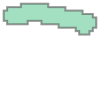

In [19]:
cells=trap_cells[0]
print(cells[1][12])
print(cells[1][12]["GFP"])
cells[1][12]["roiPoly"]

In [20]:
#%matplotlib inline 

cells_plots_t=[]

for tracked_frame in range(len(cells)):
    this_fig=draw_cell(cells,tracked_frame+1,frame_experiment_start,flims)
    cells_plots_t.append(this_fig)
    plt.close("all")

In [21]:
#%matplotlib inline 

this_tracked_plots=cells_plots_t
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    



interactive(children=(IntSlider(value=10, description='tracked_frame', max=34, min=10), Output()), _dom_classe…

___
# uJ_Tracker: Step 2

In [ ]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
 display: none;
}
</style>

In [ ]:
#global weight_vec
#weight_vec=[-.25,-.25,1,5,-5]
#[distance,angle diff,coverage,axis-intersection,relInt Diff]
%matplotlib ipympl

### Select cells to track

In [ ]:
#%matplotlib inline 
#%matplotlib notebook
%matplotlib ipympl
#%matplotlib widgets

 #if plot does not show,uncomment this line run, comment and re-run


to_track_frame=len(cells)-1
to_track_frame=14
global toTrack_roiIndex
toTrack_roiIndex=[]

global toTrack_roiFrame
toTrack_roiFrame=[]




fig=plt.figure(figsize=(15,15))
#fig=plt.figure()
ax = plt.axes()

plt.xlim(0,640)
plt.ylim(0,512)
#ax.clear()
to_track_polys=[]

for this_cell in cells[to_track_frame]:
    this_poly=this_cell['roiPoly']
    to_track_polys.append(this_poly)
    patch = PolygonPatch(this_poly, facecolor=[0.75,0.75,0.75], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)
   #ax.plot(x=100,y=100,c='r*')
ax.axis('off')


#ax.set_aspect('equal')
fig.canvas.layout.width = '1280px'
fig.canvas.layout.height = '1024px'
    

def onclickSelect(event):
    
   #global max_frames
   
   #First find if Point is inside a roi
   this_point = Point(event.xdata,event.ydata)
   
   for select_index, select_poly in enumerate(to_track_polys):
        in_roi=select_poly.contains(this_point)
        if in_roi:
            select_x,select_y = select_poly.exterior.xy     
            ax.plot(select_x, select_y, color='#6699cc', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=3)
            ax.axis('off')
            toTrack_roiIndex.append(select_index)
            toTrack_roiFrame.append(to_track_frame)
           
            break



#cid = fig.canvas.mpl_connect('button_press_event', onclickSelect)
cidx = plt.gcf().canvas.mpl_connect('button_press_event', onclickSelect)



In [ ]:
fig.canvas.mpl_disconnect(cidx)
#%matplotlib inline 

In [ ]:
toTrack_roiIndex

### Track selected cells

In [ ]:
print(toTrack_roiIndex)
print(toTrack_roiFrame)
weight_vec=[-5,-100,200,1000,-55000000,-50,-10]
weight_vec=[-5,-1,150,150,-5,-5]
#weight_vec=[-5,-100,200,500,-5,-5]
#weight_vec=[-4,-800,800,1500,-1,-1]
#[distance,angle diff,coverage,axis-intersection,flourescence Diff]


cells=clear_tracks(cells)
cells_tracked=cells.copy()

cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 

In [ ]:
%matplotlib inline 



tracked_plots=[]
for tindex,trap in enumerate(trap_list):
#    cells_tracked=trap_tracked_cells[tindex]
    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    #for tracked_frame in range(1,max_frames+1):
    for i,tracked_frame in enumerate(frames_list):
#         if(i>15 or i <5):
#             continue
        this_fig=draw_cell(cells_tracked,i+1)
        #plt.show(this_fig)
        figname="%s%s_%s-%s.png"%(dirNameFIGURES,expeLabel,trap,tracked_frame)
        print(figname)
        plt.savefig(figname)
        tracked_plots.append(this_fig)

In [ ]:
#%matplotlib inline 

max_frames=frame_experiment_end-frame_experiment_start+1


this_tracked_plots=tracked_plots
#interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=1,max=max_frames,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    


### Just cells from last frame


In [ ]:
weight_vec=[-5,-100,200,1500,-50,-50,-10]

trap_list2=[trap_list[0]]
trap_tracked_cells=[]
for tindex,trap in enumerate(trap_list2):

    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    
    
    cells=trap_cells[tindex]
    
    cells=clear_tracks(cells)
    cells_tracked=cells.copy()
    

    
    max_frames=len(cells)-1
    #max_frames=len(cells)-1

    from_frame=max_frames
    to_frame=max_frames-1
    
    for this_frame in range(from_frame,to_frame,-1):
        toTrack_roiIndex=[]
        toTrack_roiFrame=[]
        for select_index, this_cell in enumerate(cells_tracked[this_frame]):
            if len(this_cell['trackID'])==0:
                toTrack_roiFrame.append(this_frame)
                toTrack_roiIndex.append(select_index)
        print('\n___\nTracking %s cells from frame %s'%(len(toTrack_roiFrame),this_frame))
        cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 
    print('\n\nTracking complete! Trap:',trap)
    trap_tracked_cells.append(cells_tracked)
    print("\nSaving cells...")
    file_cells= list(f for f in os.listdir(dirNameCELLS) if f.endswith('.pkl'))
    file_cells.sort()
    for frame, this_file in enumerate(file_cells):
        this_cells=cells_tracked[frame] 
        #print(frame, this_file)
        fileNameTrackedCells="%s%s.pkl"%(dirNameTRACKEDCELLS,os.path.splitext(os.path.basename(this_file))[0])    
    #    print(fileNameFrameCells)
        save_cells(this_cells, fileNameTrackedCells)
    

## Tracking All

In [12]:

#[distance,angle diff,coverage,axis-intersection,flourescence Diff]
weight_vec=[-5,-1,150,150,-5,-5]

trap_tracked_cells=[]

for tindex,trap in enumerate(trap_list):
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    
    
    cells=trap_cells[tindex]
    
    cells=clear_tracks(cells)
    cells_tracked=cells.copy()
    
    max_frames=len(cells)-1
    from_frame=max_frames
    to_frame=0
    
    for this_frame in range(from_frame,to_frame,-1):
        toTrack_roiIndex=[]
        toTrack_roiFrame=[]
        for select_index, this_cell in enumerate(cells_tracked[this_frame]):
            if len(this_cell['trackID'])==0:
                toTrack_roiFrame.append(this_frame)
                toTrack_roiIndex.append(select_index)
        print('\n___\nTracking %s cells from frame %s'%(len(toTrack_roiFrame),this_frame+frame_experiment_start))
        cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 
    print('\n\nTracking complete! Trap:',trap)
    trap_tracked_cells.append(cells_tracked)
    print("\nSaving cells...")
    file_cells= list(f for f in os.listdir(dirNameCELLS) if f.endswith('.pkl'))
    file_cells.sort()
    for frame, this_file in enumerate(file_cells):
        this_cells=cells_tracked[frame] 
        #print(frame, this_file)
        fileNameTrackedCells="%s%s.pkl"%(dirNameTRACKEDCELLS,os.path.splitext(os.path.basename(this_file))[0])    
    #    print(fileNameFrameCells)
        save_cells(this_cells, fileNameTrackedCells)
    


___
Tracking 49 cells from frame 34
49/49
___
Tracking 9 cells from frame 33
9/9
___
Tracking 5 cells from frame 32
5/5
___
Tracking 6 cells from frame 31
6/6
___
Tracking 16 cells from frame 30
16/16
___
Tracking 5 cells from frame 29
5/5
___
Tracking 7 cells from frame 28
7/7
___
Tracking 6 cells from frame 27
6/6
___
Tracking 4 cells from frame 26
4/4
___
Tracking 2 cells from frame 25
2/2
___
Tracking 1 cells from frame 24
1/1
___
Tracking 1 cells from frame 23
1/1
___
Tracking 3 cells from frame 22
3/3
___
Tracking 0 cells from frame 21

___
Tracking 5 cells from frame 20
5/5
___
Tracking 5 cells from frame 19
5/5
___
Tracking 2 cells from frame 18
2/2
___
Tracking 2 cells from frame 17
2/2
___
Tracking 2 cells from frame 16
2/2
___
Tracking 4 cells from frame 15
4/4
___
Tracking 2 cells from frame 14
2/2
___
Tracking 9 cells from frame 13
9/9
___
Tracking 8 cells from frame 12
8/8
___
Tracking 2 cells from frame 11
2/2

Tracking complete! Trap: xy01

Saving cells...
Saving 28 ce

Saving 195 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_027.pkl
Saving 212 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_028.pkl
Saving 257 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_029.pkl
Saving 267 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_030.pkl
Saving 270 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_031.pkl
Saving 291 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy04/normData/MGGT-AMP-Pulse_xy04_032.pkl
Saving 259

Saving 216 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_016.pkl
Saving 219 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_017.pkl
Saving 167 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_018.pkl
Saving 168 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_019.pkl
Saving 139 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_020.pkl
Saving 126 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy06/normData/MGGT-AMP-Pulse_xy06_021.pkl
Saving 120

309/309
___
Tracking 41 cells from frame 33
41/41
___
Tracking 38 cells from frame 32
38/38
___
Tracking 47 cells from frame 31
47/47
___
Tracking 35 cells from frame 30
35/35
___
Tracking 35 cells from frame 29
35/35
___
Tracking 20 cells from frame 28
20/20
___
Tracking 24 cells from frame 27
24/24
___
Tracking 16 cells from frame 26
16/16
___
Tracking 21 cells from frame 25
21/21
___
Tracking 27 cells from frame 24
27/27
___
Tracking 16 cells from frame 23
16/16
___
Tracking 58 cells from frame 22
58/58
___
Tracking 25 cells from frame 21
25/25
___
Tracking 31 cells from frame 20
31/31
___
Tracking 75 cells from frame 19
75/75
___
Tracking 40 cells from frame 18
40/40
___
Tracking 78 cells from frame 17
78/78
___
Tracking 60 cells from frame 16
60/60
___
Tracking 57 cells from frame 15
57/57
___
Tracking 33 cells from frame 14
33/33
___
Tracking 89 cells from frame 13
89/89
___
Tracking 61 cells from frame 12
61/61
___
Tracking 72 cells from frame 11
72/72

Tracking complete! Trap: 

Saving 29 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_025.pkl
Saving 29 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_026.pkl
Saving 32 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_027.pkl
Saving 44 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_028.pkl
Saving 55 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_029.pkl
Saving 63 cells to /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy12/normData/MGGT-AMP-Pulse_xy12_030.pkl
Saving 80 cells 

### Load tracked cells

In [14]:
max_frames2=-1
trap_tracked_cells=[]
for tindex,trap in enumerate(trap_list):

    #dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    print(dirNameTRACKEDCELLS)
    tracked_cells=load_cells(dirNameTRACKEDCELLS,max_frames2)
    trap_tracked_cells.append(tracked_cells)

/home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/data_cells_tracked/xy01/normData/
0: Loading MGGT-AMP-Pulse_xy01_010.pkl
1: Loading MGGT-AMP-Pulse_xy01_011.pkl
2: Loading MGGT-AMP-Pulse_xy01_012.pkl
3: Loading MGGT-AMP-Pulse_xy01_013.pkl
4: Loading MGGT-AMP-Pulse_xy01_014.pkl
5: Loading MGGT-AMP-Pulse_xy01_015.pkl
6: Loading MGGT-AMP-Pulse_xy01_016.pkl
7: Loading MGGT-AMP-Pulse_xy01_017.pkl
8: Loading MGGT-AMP-Pulse_xy01_018.pkl
9: Loading MGGT-AMP-Pulse_xy01_019.pkl
10: Loading MGGT-AMP-Pulse_xy01_020.pkl
11: Loading MGGT-AMP-Pulse_xy01_021.pkl
12: Loading MGGT-AMP-Pulse_xy01_022.pkl
13: Loading MGGT-AMP-Pulse_xy01_023.pkl
14: Loading MGGT-AMP-Pulse_xy01_024.pkl
15: Loading MGGT-AMP-Pulse_xy01_025.pkl
16: Loading MGGT-AMP-Pulse_xy01_026.pkl
17: Loading MGGT-AMP-Pulse_xy01_027.pkl
18: Loading MGGT-AMP-Pulse_xy01_028.pkl
19: Loading MGGT-AMP-Pulse_xy01_029.pkl
20: Loading MGGT-AMP-Pulse_xy01_030.pkl
21: Loading MGGT-AMP-Pulse_xy01_031.pkl
22: Loading 

12: Loading MGGT-AMP-Pulse_xy13_022.pkl
13: Loading MGGT-AMP-Pulse_xy13_023.pkl
14: Loading MGGT-AMP-Pulse_xy13_024.pkl
15: Loading MGGT-AMP-Pulse_xy13_025.pkl
16: Loading MGGT-AMP-Pulse_xy13_026.pkl
17: Loading MGGT-AMP-Pulse_xy13_027.pkl
18: Loading MGGT-AMP-Pulse_xy13_028.pkl
19: Loading MGGT-AMP-Pulse_xy13_029.pkl
20: Loading MGGT-AMP-Pulse_xy13_030.pkl
21: Loading MGGT-AMP-Pulse_xy13_031.pkl
22: Loading MGGT-AMP-Pulse_xy13_032.pkl
23: Loading MGGT-AMP-Pulse_xy13_033.pkl
24: Loading MGGT-AMP-Pulse_xy13_034.pkl


### Draw ROIs + Tracked Cells

In [15]:
trap_list

['xy01', 'xy04', 'xy05', 'xy06', 'xy07', 'xy09', 'xy12', 'xy13']

In [16]:
%matplotlib inline
#max_frames=len(cells_tracked)
trap_tracked_plots=[]
for tindex,trap in enumerate(trap_list):
    tracked_plots=[]
    cells_tracked=trap_tracked_cells[tindex]
    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    print("Trap: %s in %s"%(trap,dirNameFIGURES))
    for i,tracked_frame in enumerate(frames_list):
        this_fig=draw_cell(cells_tracked,i+1,frame_experiment_start,flims)
        #plt.show(this_fig)
        tracked_frame_name=str(tracked_frame).zfill(3)
        figname="%s%s_%s-%s.png"%(dirNameFIGURES,expeLabel,trap,tracked_frame_name)
        this_fig.savefig(figname)
        tracked_plots.append(this_fig)
       # display(this_fig)
        plt.close("all")
    print()
    trap_tracked_plots.append(tracked_plots)

Trap: xy01 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy01/normData/
Building plot for frame frame 35 
Trap: xy04 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy04/normData/
Building plot for frame frame 35 
Trap: xy05 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy05/normData/
Building plot for frame frame 35 
Trap: xy06 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy06/normData/
Building plot for frame frame 35 
Trap: xy07 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy07/normData/
Building plot for frame frame 35 
Trap: xy09 in /home/charly/Lab/Projects/uJ/uJ_data/MGGT-AMP-Pulse/20190828_Bruno_MGGT_quimiostato/figures/traked_cells/xy09/normData/
Building plot for frame fr

In [18]:
len(trap_tracked_plots)

8

In [17]:
#%matplotlib inline 

max_frames=frame_experiment_end-frame_experiment_start+1


this_tracked_plots=trap_tracked_plots[5]
#interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=1,max=max_frames,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    



interactive(children=(IntSlider(value=10, description='tracked_frame', max=34, min=10), Output()), _dom_classe…

In [ ]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
 display: none;
}
</style>